# Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install & Import Package

In [ ]:
# !pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install monai

     |████████████████████████████████| 721 kB 5.1 MB/s 


In [ ]:
import os

os.chdir('/content/drive/MyDrive/AI/Liver_segmentation')
os.getcwd()

'/content/drive/MyDrive/AI/Liver_segmentation'

In [ ]:
from preprocess import preprocess
import random
from glob import glob
from monai.transforms import (
                                LoadImaged,
                                AddChanneld,
                                Spacingd,   # affine field를 새로 씀
                                Orientationd,   # 방향전환
                                ScaleIntensityRanged,   # output intensity 범위 조정
                                CropForegroundd,
                                RandFlipd,
                                RandRotate90d,
                                Resized,
                                ToTensord,
                                Compose,
                                )

import torch
from torch import nn

import numpy as np
from tqdm import tqdm
import monai
from monai.data import decollate_batch


import matplotlib.pyplot as plt
import time

# Prepare Dataset

In [ ]:
dir = os.getcwd() + '/nifti_files'
train, valid = preprocess(image_path = dir+'/images', label_path = dir+'/labels',  
                          test_size=0.3, a_min=-60, a_max=40, 
                          train_batch=20, valid_batch=10, shuffle=True)

In [ ]:
sample = next(iter(train))
image = sample['image']
label = sample['label']

image.shape, label.shape

(torch.Size([20, 1, 64, 64, 32]), torch.Size([20, 1, 64, 64, 32]))

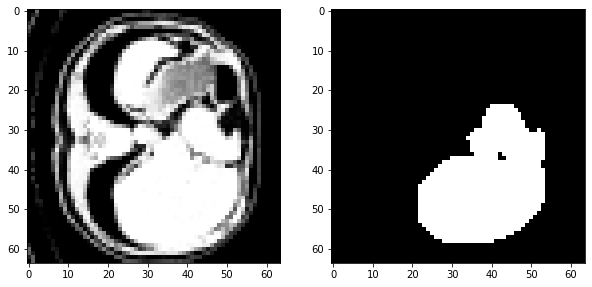

In [ ]:
i, j = 12, 31

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[i, 0, ..., j], 'gray')

plt.subplot(1, 2, 2)
plt.imshow(label[i, 0, ..., j], 'gray')

# Trainer

In [ ]:
class Liver_Seg_Trainer(nn.Module):
  def __init__(self, model, loss,  metric, opt, has_scheduler=False, device='cpu'):
    super().__init__()

    self.model = model
    self.loss = loss
    self.metric = metric
    self.opt = opt

    self.has_scheduler = has_scheduler
    if self.has_scheduler:
      self._get_scheduler()

    self.device = device

  def _get_scheduler(self):
    self.scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=self.opt, gamma=0.3, last_epoch=20, verbose=True)

  def dice_coefficient(self, prediction, target):

    target = target.squeeze(1).permute(0, 3, 1, 2).to('cpu')
    target = [i for i in decollate_batch(target)]
    prediction = torch.argmax(prediction.to('cpu'), axis=1).permute(0, 3, 1, 2)
    prediction = [i for i in decollate_batch(prediction)]
    self.metric(prediction, target)
    dicemetric = self.metric.aggregate().item()

    return dicemetric

  def train(self, train_loader, valid_loader, max_epochs, model_dir):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_valid = []
    save_metric_train = []
    save_metric_valid = []

    for epoch in range(max_epochs):
      print(f'epoch {epoch+1}/{max_epochs}')
    
    # Train
      train_epoch_loss, train_epoch_metric = self.train_epoch(train_loader)
      # loss save
      save_loss_train.append(train_epoch_loss)
      np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
      # metric save
      save_metric_train.append(train_epoch_metric)
      np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

    # Valid
      valid_epoch_loss, valid_epoch_metric = self.valid_epoch(valid_loader)
      # loss save
      save_loss_valid.append(valid_epoch_loss)
      np.save(os.path.join(model_dir, 'loss_valid.npy'), save_loss_valid)
      # metric save
      save_metric_valid.append(valid_epoch_metric)
      np.save(os.path.join(model_dir, 'metric_valid.npy'), save_metric_valid)

    # Show Plot
      self.show_plot(save_loss_train, save_loss_valid, save_metric_train, save_metric_valid)

      if valid_epoch_metric > best_metric:
        best_metric = valid_epoch_metric
        best_metric_epoch = epoch+1
        if not os.path.exists(os.path.join(model_dir, 'best')):
          os.mkdir(os.path.join(model_dir, 'best'))
        torch.save(model.state_dict(), os.path.join(model_dir, 'best', 'best_metric_model.pth'))

      print(f'Current Epoch: {epoch+1} Current Dice Codfficient: {valid_epoch_metric:.5f}\n'
            f'Best Mean Dice : {best_metric :.5f}  at epoch {best_metric_epoch}\n')

    print(f'Train Complete',
          f'Best_metric is {best_metric :.5f} at epoch {best_metric_epoch}')

  def train_epoch(self, train_loader):
      print('========== Train Start ==========')
      self.model.train()

      train_epoch_loss = 0
      train_step = 0
      train_epoch_metric = 0

      for data in train_loader:
        train_step += 1

        image = data['image']
        label = data['label']
        label[label>0]=1
        image, label = (image.to(self.device), label.to(self.device))

        train_out = self.model(image)
        train_loss = self.loss(train_out, label)

        self.opt.zero_grad()
        train_loss.backward()
        self.opt.step()

        train_epoch_loss += train_loss.item()

        train_metric = self.dice_coefficient(train_out, label)
        train_epoch_metric += train_metric
        print(f'{train_step}/{len(train_loader)} Train Loss: {train_loss.item():.5f} Train Dice Coefficient: {train_metric:.5f}')

      self.metric.reset()
      train_epoch_loss /= train_step
      print(f'\nTrain Epoch Loss : {train_epoch_loss:.5f}')

      train_epoch_metric /= train_step
      print(f'Train Epoch Metric : {train_epoch_metric:.5f}')

      return train_epoch_loss, train_epoch_metric

  def valid_epoch(self, valid_loader):
    print('\n========== Valid Start ==========')
    self.model.eval()
    
    with torch.no_grad():
      valid_epoch_loss = 0
      valid_step = 0
      valid_epoch_metric = 0

      for data in valid_loader:
        valid_step += 1
        
        image = data['image']
        label = data['label']
        label[label>0]=1
        image, label = (image.to(self.device), label.to(self.device))

        valid_out = self.model(image)
        valid_loss = self.loss(valid_out, label)
        valid_epoch_loss += valid_loss.item()

        valid_metric = self.dice_coefficient(valid_out, label)
        valid_epoch_metric += valid_metric
        print(f'{valid_step}/{len(valid_loader)} Valid Loss: {valid_loss.item():.5f} Valid Dice Coefficient: {valid_metric:.5f}')

      self.metric.reset()
      valid_epoch_loss /= valid_step
      print(f'\nValid Epoch Loss : {valid_epoch_loss:.5f}')

      valid_epoch_metric /= valid_step
      print(f'Valid Epoch Metric : {valid_epoch_metric:.5f}\n')

      return valid_epoch_loss, valid_epoch_metric

  def show_plot(self, train_loss, valid_loss, train_metric, valid_metric):

    plt.figure(figsize=(16, 8))
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(train_loss, 'o-r', label = 'Train Loss')
    ax1.plot(valid_loss, '*-b', label = 'Valid Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(train_metric, 'o-r', label='Train Metric')
    ax2.plot(valid_metric, '*-b', label='Valid Metric')
    ax2.set_title('Dice Coefficient')
    ax2.legend()

    plt.show()



# Train

In [ ]:
device = torch.device("cuda:0")
model = monai.networks.nets.UNet(
    # spatial_dims=3,
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=monai.networks.layers.Norm.BATCH,
).to(device)

loss = monai.losses.DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True, reduction='mean', include_background=True)

dice= monai.metrics.DiceMetric(include_background=True, reduction='mean', )

opt = torch.optim.Adam(params=model.parameters(), lr = 1e-4, 
                       weight_decay=1e-5, 
                       amsgrad=True,
                       )

In [ ]:
trainer = Liver_Seg_Trainer(
    model=model, 
    loss=loss,
    metric=dice,
    opt=opt, 
    device=device,
    # has_scheduler=False
)

model_dir= '/content/drive/MyDrive/AI/Liver_segmentation/model'

start = time.time()
trainer.train(train, valid, max_epochs=100, model_dir=model_dir, )
print(f'Training Time : {time.time()-start}')

Output hidden; open in https://colab.research.google.com to view.

# Confirm Result

In [ ]:
model_dir = '/content/drive/MyDrive/AI/Liver_segmentation/model'

train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
valid_loss = np.load(os.path.join(model_dir, 'loss_valid.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
valid_metric = np.load(os.path.join(model_dir, 'metric_valid.npy'))

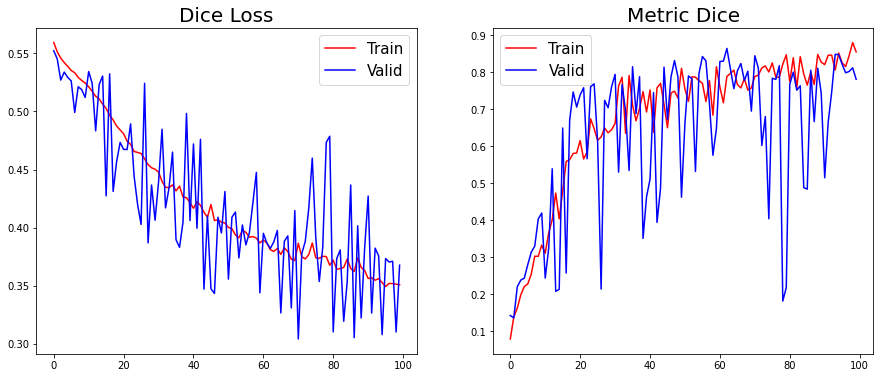

In [ ]:
plt.figure(figsize = (15, 6))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(train_loss, 'red', label='Train')
ax1.plot(valid_loss, 'blue', label = 'Valid') 
ax1.set_title('Dice Loss')
ax1.title.set_size(20)
ax1.legend(fontsize=15)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(train_metric, 'red', label='Train')
ax2.plot(valid_metric, 'blue', label = 'Valid') 
ax2.set_title('Metric Dice')
ax2.title.set_size(20)
ax2.legend(fontsize=15)

### 참고 링크
http://medicaldecathlon.com/  
https://monai.io/  
https://www.kaggle.com/andrewmvd/liver-tumor-segmentation  
https://www.kaggle.com/andrewmvd/liver-tumor-segmentation-part-2  
https://www.youtube.com/watch?v=M3ZWfamWrBM&list=WL&index=29&t=11460s  
  
- github link  
https://github.com/amine0110/nifti2dicom/blob/main/nifti2dicom.py  
https://github.com/amine0110/Liver-Segmentation-Using-Monai-and-PyTorch  
